## Brand over all sentiment on Reddit


In [35]:
import requests
import pandas as pd
import praw
from praw.models import MoreComments

import os
import zipfile
import ast
import re
# Tools for text analysis
# We can use nltk to extract adjective and verbs related to the product/brand 
import nltk
from nltk import pos_tag
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from nltk.corpus import stopwords as nltk_stopwords
# Vader sentiment analysis 
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from rapidfuzz import process, fuzz
import matplotlib.pyplot as plt

os.makedirs("../output", exist_ok=True)
from dotenv import load_dotenv
load_dotenv()

True

# Comment analysis

The post are searched by keywords using product question and review tag to keep post topic narrowed to specific brand. However, the comment can be mentioning other brand, so to improve the accuracy of sentiment analysis we will be tokenizing the comments.

In [121]:
analyzer = SentimentIntensityAnalyzer() 
comment_df = pd.read_csv("../output/subreddit_comment_data.csv")
all_brands = pd.read_csv("../output/all_brands.csv")
brand_list = all_brands["brand_name"].str.lower().str.strip()
brand_set = set(brand_list)
comment_df


,post_id,title,brand,subreddit_name,comment,cleaned_comment
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,Return it? Give it to someone?,return give someone
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,Estée Lauder,SkincareAddiction,You can try to use it on your chest area to se...,try use chest area see tolerated otherwise wou...
2,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,I've used this serum for years and it's one of...,used serum years one favourites use couple dro...
3,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,"The more you use, the faster you use it up and...",use faster use sooner replace course company w...
4,psd79w,[Product Question] Estée Lauder Advanced Night...,Estée Lauder,SkincareAddiction,Most serums just need a few drops to cover the...,serums need drops cover face see half dropper ...
...,...,...,...,...,...,...
4513,1928sit,COSRX Advance Snail 96 Mucin Power Essence vs ...,COSRX,IndianSkincareAddicts,Guy here have both. Bought the essence first a...,guy bought essence first cream pick one go ess...
4514,1928sit,COSRX Advance Snail 96 Mucin Power Essence vs ...,COSRX,IndianSkincareAddicts,Combination skin here- used essence in summers...,combination skin used essence summers switched...
4515,1928sit,COSRX Advance Snail 96 Mucin Power Essence vs ...,COSRX,IndianSkincareAddicts,Cream - I like that also and while it goes on ...,cream like also goes oily spreads easily makes...
4516,1928sit,COSRX Advance Snail 96 Mucin Power Essence vs ...,COSRX,IndianSkincareAddicts,You should do a patch test before using it reg...,patch test using regularly people like allergi...


In [122]:
brand_mapping = {
    'fenty': 'Fenty Beauty',
    'etude': 'Etude House',
    'e.l.f.': 'e.l.f. Cosmetics',
    'elf': 'e.l.f. Cosmetics'
}
comment_df = comment_df.dropna(subset=["brand"])

def normalize_brand(name):
    return brand_mapping.get(name.lower().strip(), name.strip())

# Apply to `search_term` column after creating comment_df
comment_df["normalized_brand"] = comment_df["brand"].apply(normalize_brand)

comment_df[comment_df["subreddit_name"] == "IndianSkincareAddicts"]['normalized_brand'].unique()

/var/folders/rg/04c1t0sd7zdc_6sl31l_r9km0000gn/T/ipykernel_21221/486244803.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  comment_df["normalized_brand"] = comment_df["brand"].apply(normalize_brand)


array(['Estée Lauder', 'e.l.f. Cosmetics', 'Glossier', 'Laneige',
       'Sulwhasoo', 'Etude House', 'Innisfree', 'COSRX'], dtype=object)

In [123]:

comment_rows = []

# Search for mentioning of brand value ?
# tagging brand to the comment and getting the sentiment score

def brand_word_match(comment):
    # store every word as a a set 
    words = set(re.findall(r'\b\w+\b', comment.lower()))
    exact_matches = words & brand_set
    if exact_matches:
        return exact_matches
    # check for more causal mention of brand 
    found = process.extract(
        query=comment,
        choices=brand_list,
        scorer=fuzz.partial_ratio,
        limit=10
    )
    return {match for match, score, _ in found if score >= 85}


for _, row in comment_df.iterrows():
    target_brand = row["normalized_brand"]
    comment = row["cleaned_comment"]
    # check if comment is a string and not empty
    if not isinstance(comment, str) or not comment.strip():
        continue
    if not isinstance(target_brand, str) or not target_brand.strip():
        continue
    
    comment_lower = comment.lower()
    mentioned_brands = brand_word_match(comment_lower)

    if not mentioned_brands or mentioned_brands == {target_brand}:
        sentiment_score = analyzer.polarity_scores(comment)["compound"]
        sentiment_label = (
            "positive" if sentiment_score > 0.05
            else "negative" if sentiment_score < -0.05
            else "neutral"
        )
        comment_rows.append({
            "post_id": row["post_id"],
            "title": row["title"],
            "comment": comment,
            "normalized_brand": target_brand,
            "subreddit_name": row["subreddit_name"],
            "sentiment_score": sentiment_score,
            "sentiment_label": sentiment_label
        })

comment_df = pd.DataFrame(comment_rows)
print(comment_df.sentiment_label.value_counts())


comment_df.to_csv("../output/subreddit_sentiment_data.csv", index=False)
comment_df.head()

sentiment_label
positive    600
neutral     235
negative    117
Name: count, dtype: int64


,post_id,title,comment,normalized_brand,subreddit_name,sentiment_score,sentiment_label
0,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,return give someone,Estée Lauder,SkincareAddiction,0.0000,neutral
1,1bv7f30,[Product Question] Estée Lauder ANR - Allergic,try use chest area see tolerated otherwise wou...,Estée Lauder,SkincareAddiction,0.4939,positive
2,psd79w,[Product Question] Estée Lauder Advanced Night...,hi one feel like serum bottle close properly t...,Estée Lauder,SkincareAddiction,0.3612,positive
3,lx8cl1,[product question] Estée Lauder ANR smell,years old yeah dump,Estée Lauder,SkincareAddiction,-0.1027,negative
4,6swic4,[Product Question] Estée Lauder advanced night...,pretty sure supposed dupe ingredients preventi...,Estée Lauder,SkincareAddiction,0.9445,positive


['SkincareAddiction' 'Sephora' 'Blackskincare' 'AsianBeauty'
 'KoreanBeauty' 'BrownBeauty' 'IndianSkincareAddicts']
   normalized_brand  sentiment_score
0             COSRX         0.246954
1      Estée Lauder         0.299486
2       Etude House         0.364762
3      Fenty Beauty         0.300289
4          Glossier         0.363598
5         Innisfree         0.328030
6           Laneige         0.287076
7         Sulwhasoo         0.324980
8             Tarte         0.408300
9  e.l.f. Cosmetics         0.307444


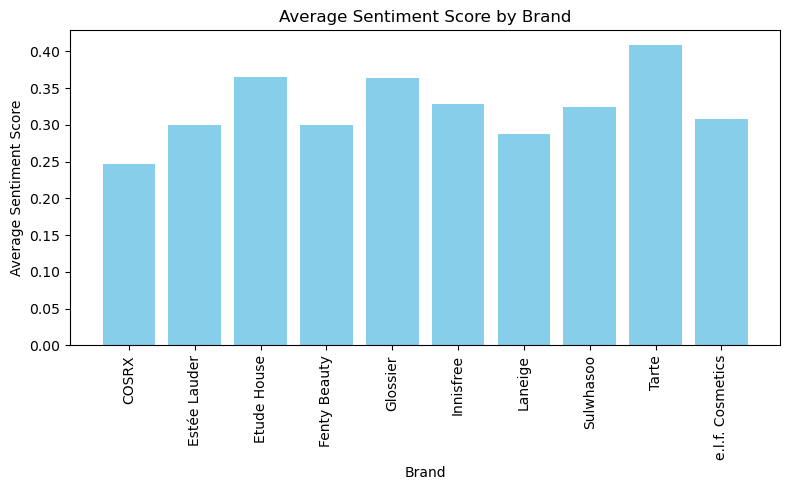

In [124]:
print(comment_df["subreddit_name"].unique())
avg_sentiment = comment_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()

print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score by Brand")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


   normalized_brand  sentiment_score
0             COSRX         0.221959
1      Estée Lauder         0.428522
2       Etude House         0.546700
3      Fenty Beauty         0.019467
4          Glossier         0.371797
5         Innisfree         0.326404
6           Laneige         0.414093
7         Sulwhasoo         0.445977
8             Tarte         0.418880
9  e.l.f. Cosmetics         0.433865


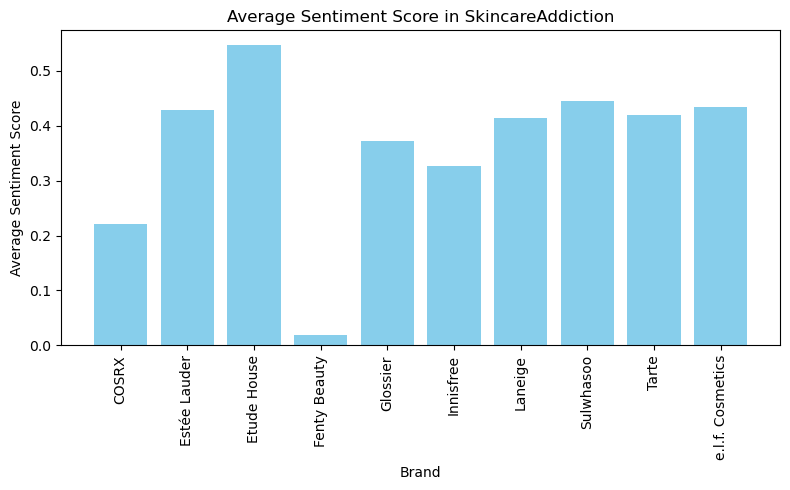

In [125]:
# Avg sentiment by SkincareAddiction
skincare_addiction_df = comment_df[comment_df["subreddit_name"] == "SkincareAddiction"]
avg_sentiment = skincare_addiction_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()


print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score in SkincareAddiction")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()



   normalized_brand  sentiment_score
0             COSRX         0.219854
1       Etude House         0.371700
2          Glossier         0.323900
3         Innisfree         0.136468
4           Laneige         0.199052
5         Sulwhasoo         0.233891
6  e.l.f. Cosmetics        -0.458800


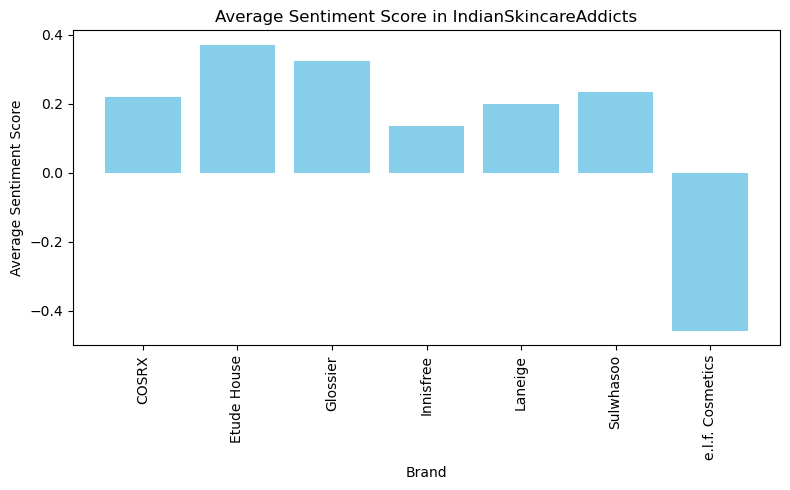

In [126]:
# Avg sentiment by IndianSkincareAddicts
skincare_addiction_df = comment_df[comment_df["subreddit_name"] == "IndianSkincareAddicts"]
avg_sentiment = skincare_addiction_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()


print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score in IndianSkincareAddicts")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()


   normalized_brand  sentiment_score
0      Fenty Beauty          0.48845
1           Laneige          0.54518
2  e.l.f. Cosmetics          0.59940


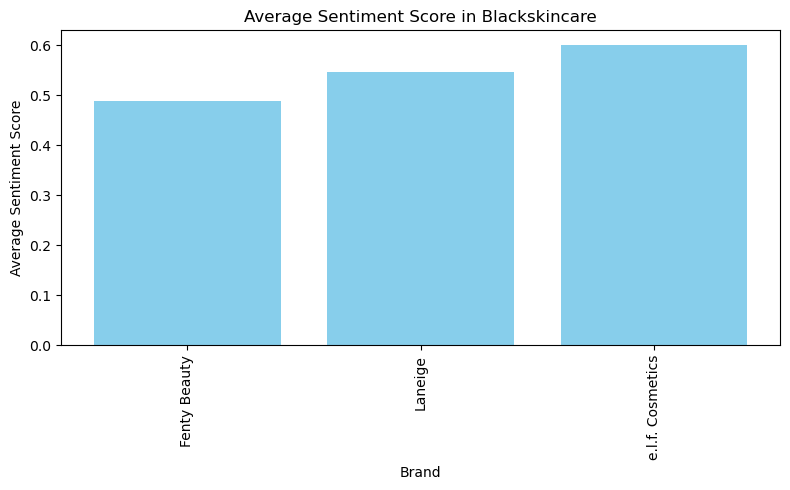

In [127]:
# Avg sentiment by Blackskincare
skincare_addiction_df = comment_df[comment_df["subreddit_name"] == "Blackskincare"]
avg_sentiment = skincare_addiction_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()


print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score in Blackskincare")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

  normalized_brand  sentiment_score
0     Fenty Beauty         0.506877
1         Glossier         0.329733
2          Laneige         0.802000
3            Tarte         0.490967


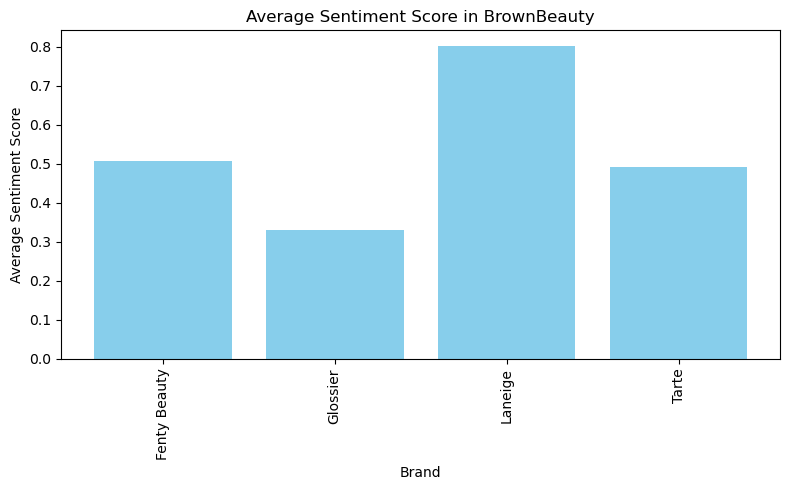

In [128]:
# Avg sentiment by BrownBeauty
skincare_addiction_df = comment_df[comment_df["subreddit_name"] == "BrownBeauty"]
avg_sentiment = skincare_addiction_df.groupby("normalized_brand")["sentiment_score"].mean().reset_index()


print(avg_sentiment)
plt.figure(figsize=(8, 5))
plt.bar(avg_sentiment["normalized_brand"], avg_sentiment["sentiment_score"], color='skyblue')
plt.xlabel("Brand")
plt.ylabel("Average Sentiment Score")
plt.title("Average Sentiment Score in BrownBeauty")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()